# CRpropa simulation

Set up a 3D simulation with energy losses to mimic the case used in the generative model to test the arrival direction and joint models. To install CRPropa, see the info [here](https://github.com/CRPropa/CRPropa3).
<br>
<br>
Summary of the assumptions:
* Only protons
* Random turbulent B field with $B_\rm{RMS} = B \ \rm{nG}$
<br>
<br>

In [1]:
# KW: need to add path to crpropa to PYTHONPATH to allow search of CRPropa3 as python module
import sys
import os

# modify below to your path to crpropa/lib/python/site-packages
path_to_crpropa = "/opt/CRPropa3/lib/python3.8/site-packages"
sys.path.append(path_to_crpropa)

# check if the correct path is added to PYTHONPATH
# print(sys.path)


In [2]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

from crpropa import *

from fancy.interfaces.stan import Direction 
from fancy.plotting import AllSkyMap
from fancy import Data, Model, Analysis, Results
from fancy.detector.auger2014 import detector_properties
from fancy.propagation.energy_loss import get_source_threshold_energy

## Data
Read in the same data and output of the generative model simulation.

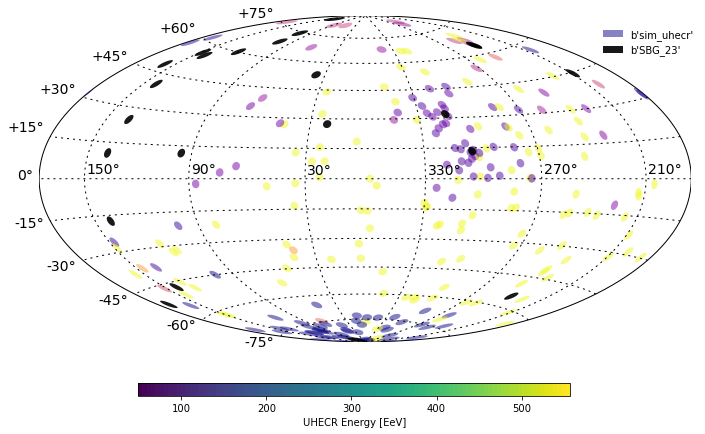

In [3]:
# Read in relevant data
sim_output_file = '../arrival_vs_joint/output/joint_model_simulation.h5'

data = Data()
data.from_file(sim_output_file)
data.show()

# Other useful info
with h5py.File(sim_output_file, 'r') as f:
    source_labels = f['uhecr/source_labels'][()]
    Eth = f['model/Eth'][()]
    Eth_sim = f['model/Eth_sim'][()]
    alpha = f['model/alpha'][()]
    B = f['model/B'][()]
    f_E = f['detector/f_E'][()]

In [4]:
# Get source vectors for CRPropa
source_vectors = []
for i, uv in enumerate(data.source.unit_vector):
    # add 1 Mpc to counter detection effects
    v = Vector3d(uv[0], uv[1], uv[2]) * (data.source.distance[i] + 1.0) 
    source_vectors.append(v)

In [5]:
# Define desired number of source events and save background events
lambda0 = data.source.N
Nbg = list(source_labels).count(lambda0)
Nsrc = data.uhecr.N - Nbg

bg_i = np.where(source_labels == lambda0)
Edet_bg = data.uhecr.energy[bg_i]
uv_bg = data.uhecr.unit_vector[bg_i]

## Magnetic field model

In [6]:
random_seed = 42
l_c = 1 # Mpc
n = 500
spacing = 100 # kpc
Lmin = 1000 # kpc
Lmax = 3135 # kpc

# KW: VectorGrid is deprecated in favor of Grid3f
# https://github.com/CRPropa/CRPropa3/blob/master/include/crpropa/Grid.h 
# vgrid = VectorGrid(Vector3d(0), n, spacing * kpc)
vgrid = Grid3f(Vector3d(0), n, spacing * kpc)
initTurbulence(vgrid, B * nG, Lmin * kpc, Lmax * kpc, -11.0 / 3.0, random_seed)
Bfield = MagneticFieldGrid(vgrid)

# Print B field properties
# print some properties of our field
print ('Lc = %.1f kpc' % turbulentCorrelationLength(Lmin, Lmax, -11/3.)) 
print ('<B^2> = %.1f nG' % (rmsFieldStrength(vgrid) / nG))   # RMS
print ('<|B|> = %.1f nG' % (meanFieldStrength(vgrid) / nG))  # mean
print ('B(10 Mpc, 0, 0) =', Bfield.getField(Vector3d(10,0,0) * Mpc) / nG, 'nG')
print('size:', n * spacing / 1e3, 'Mpc')

Lc = 1000.9 kpc
<B^2> = 20.0 nG
<|B|> = 18.4 nG
B(10 Mpc, 0, 0) = Vector(-0.175969, 0.0143474, 0.162224) nG
size: 50.0 Mpc


In [7]:
# check Lc with Harari et al. (2002) calculation
def Lc(Lmin, Lmax, n):
    return 0.5 * Lmax * ((n-1) / n) * ((1 - (Lmin/Lmax)**n) / (1 - (Lmin/Lmax)**(n-1)))

print ('Lc (CRPropa) = %.1f kpc' % turbulentCorrelationLength(Lmin, Lmax, -11/3.)) 
print('Lc (Harari et al.) = %.1f kpc' % Lc(1000, 3135, 5./3.))

Lc (CRPropa) = 1000.9 kpc
Lc (Harari et al.) = 1000.9 kpc


## Sources

In [8]:
sources = []
for i, v in enumerate(source_vectors):
    s = Source()
    s.add( SourcePosition((v) * Mpc) )
    s.add( SourceParticleType(nucleusId(1, 1)) )
    s.add( SourcePowerLawSpectrum(Eth_sim * EeV, 1e4 * EeV, -alpha) )
    s.add( SourceIsotropicEmission() )
    sources.append(s)

source_list = SourceList()
Ns = len(sources)
for s in sources:
    source_list.add(s, (1 / Ns))

## Simulation

The simulation takes a while to run, so one can simply skip this section. However, if you want to run the simulation, the event output text file must be modified to match the input file in the next section. 

In [9]:
# KW: CMB class is PhotonField::BlackbodyPhotonField object
#     which is incompatible with arg in PhotoPionProduction
# lowercase to distinguish from CMB class
cmb = BlackbodyPhotonField("CMB", 2.73)

# KW: IRB object is not defined anymore in CRPropa, instead irb is defined for specific models. 
# selection listed here:
# "IRB_Kneiske04", "IRB_Stecker05", "IRB_Franceschini08", "IRB_Finke10"
# "IRB_Dominguez11", "IRB_Gilmore12", "IRB_Stecker16_upper"
# "IRB_Stecker16_lower"
# True argument for redshift dependency
irb = TabularPhotonField("IRB_Stecker16_lower", True)

sim = ModuleList()
sim.add( PropagationCK(Bfield) )
sim.add( PhotoPionProduction(cmb) )
sim.add( PhotoPionProduction(irb) )
sim.add( PhotoDisintegration(cmb) )
sim.add( PhotoDisintegration(irb) )
sim.add( ElectronPairProduction(cmb) )
sim.add( ElectronPairProduction(irb) )
sim.add( NuclearDecay() )
sim.add( MinimumEnergy( Eth_sim * EeV) )

# Observer
obs = Observer()
obs.add( ObserverSurface( Sphere(Vector3d(0, 0, 0,), 1.0 * Mpc)) )
sim.add(obs)

# Event output
output = TextOutput('output/crpropa_events.txt', Output.Event3D)
obs.onDetection(output)

In [10]:
# Run
N = 500000 

sim.setShowProgress(True)  
sim.run(source_list, N)
output.close()

### Visualise simulation output

In [11]:
# Spectrum
np.random.seed(5)

output_data = np.genfromtxt('output/paper_crpropa_events.txt', names = True)
N_event = len(output_data)
print ('Number of events:', N_event)

E = output_data['E0']
Earr = output_data['E']

# Detection effects
Edet = np.array([np.random.normal(e, e * f_E) for e in Earr])
ind_cut = np.where(Edet > Eth)[0]
Edet = Edet[ind_cut]
print('Number above events above energy threshold:', len(ind_cut))

bins = np.logspace(np.log(min(E)), np.log(max(E)), base = np.e)

Number of events: 5159
Number above events above energy threshold: 429


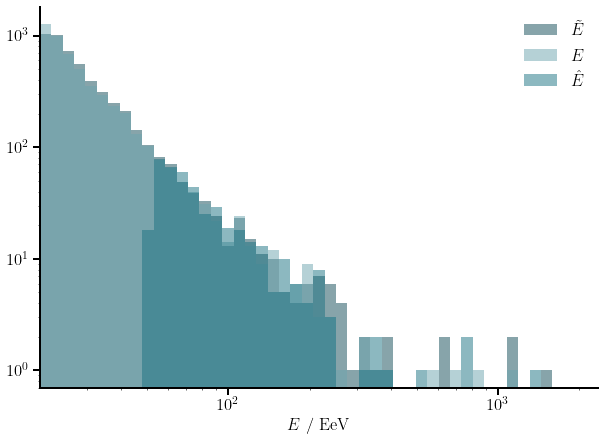

In [12]:
plt.style.use(['minimalist', 'blues'])

# Plot the spectrum
fig, ax = plt.subplots()
fig.set_size_inches((10, 7))
ax.hist(E, bins = bins, alpha = 0.5, label = r'$\tilde{E}$')
ax.hist(Earr, bins = bins, alpha = 0.5, label = '$E$')
ax.hist(Edet, bins = bins, alpha = 0.5, label = '$\hat{E}$')
ax.set_xlabel('$E$ / EeV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

In [13]:
# Arrival directions
unit_vector = []
Px = output_data['Px'][ind_cut]
Py = output_data['Py'][ind_cut]
Pz = output_data['Pz'][ind_cut]

for i in range(len(Px)):
    unit_vector.append([-Px[i], 
                        -Py[i], 
                        -Pz[i]])
arr_dir = Direction(unit_vector)
source_dir = Direction(data.source.unit_vector) 

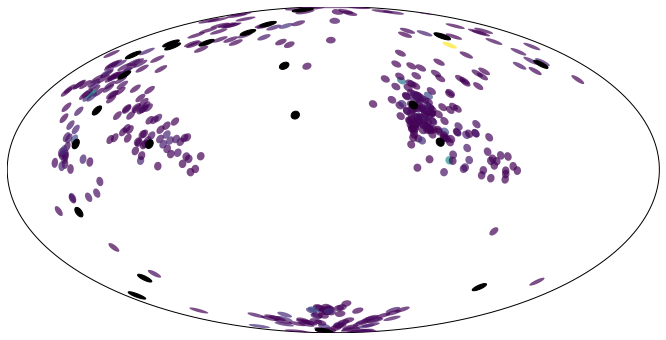

In [14]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0)

norm_E = Normalize(min(Edet), max(Edet))
cmap = plt.cm.get_cmap('viridis')
    
for e, lon, lat in np.nditer([Edet, arr_dir.lons, arr_dir.lats]):
    color = cmap(norm_E(e))
    skymap.tissot(lon, lat, 2.0, 30, alpha = 0.7, facecolor = color)
for lon, lat in np.nditer([source_dir.lons, source_dir.lats]):
    skymap.tissot(lon, lat, 2.0, 30, color = 'k', alpha = 1)

### Detector exposure effects

Now add in the effect of the Pierre Auger Observatory exposure, as was done in the Stan simulation.

In [15]:
from fancy.detector.exposure import m
from fancy.detector.auger2014 import detector_params, kappa_d
from fancy.detector.vMF.vmf import sample_vMF

In [16]:
# Exposure
m_max = m(np.pi, detector_params)
theta = [np.arccos(uv[2]) for uv in arr_dir.unit_vector]
selection = []
for i, t in enumerate(theta):
    pdet = m(t, detector_params) / m_max
    accept = np.random.choice([0, 1], p = [pdet, 1 - pdet])
    if accept == 0:
        selection.append(i)

arr_dir_uv = [arr_dir.unit_vector[i] for i in selection]
# Edet = [Edet[i] for i in selection]        
print(len(selection), 'UHECR detected')

# Reconstruction uncertainty
arr_dir_uv = [sample_vMF(np.array(ad), kappa_d, 1)[0] for ad in arr_dir_uv]

# Make proper unit vectors
arr_dir_uv = [a / np.linalg.norm(a) for a in arr_dir_uv]

176 UHECR detected


In [17]:
# Randomly select Nsrc source events to match generative model simulation
Ndet = len(selection)
inds = np.random.choice(Ndet, Nsrc) 
Edet = [Edet[i] for i in inds]
arr_dir_uv = [arr_dir_uv[i] for i in inds]

# Add background from generative model simulaiton
total_Edet = list(Edet) + list(Edet_bg)
total_arr_dir_uv = list(arr_dir_uv) + list(uv_bg)
total_arr_dir = Direction(total_arr_dir_uv)
print('Total # of UHECRs:', len(total_Edet))

Total # of UHECRs: 249


### Visualise final CRPropa data set 

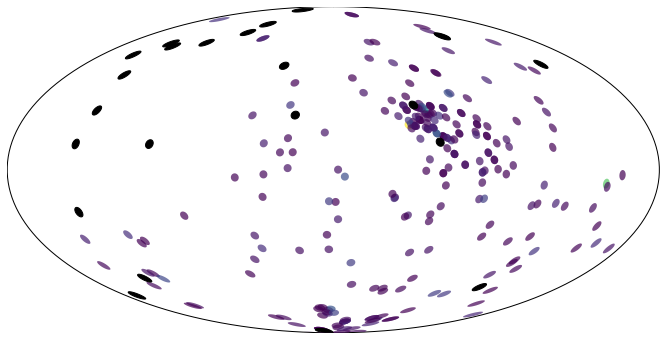

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0)

norm_E = Normalize(min(total_Edet), max(total_Edet))
cmap = plt.cm.get_cmap('viridis')

for e, lon, lat in np.nditer([total_Edet, total_arr_dir.lons, total_arr_dir.lats]):
    color = cmap(norm_E(e))
    skymap.tissot(lon, lat, 2.0, 30, alpha = 0.7, facecolor = color)
for lon, lat in np.nditer([source_dir.lons, source_dir.lats]):
    skymap.tissot(lon, lat, 2.0, 30, color = 'k', alpha = 1)

### Save to file

In [19]:
crpropa_sim_output = 'output/crpropa_sim.h5'

with h5py.File(crpropa_sim_output, 'w') as f:
    uhecr = f.create_group('uhecr')
    uhecr.create_dataset('energy', data = total_Edet)
    uhecr.create_dataset('unit_vector', data = total_arr_dir_uv)